In [1]:
import os
import json
import numpy as np
from matplotlib import pyplot as plt
from scgt import GeoTiff, Tile
from birdmaps import bird_runs
from birdmaps import ebird_db

In [2]:
LOCAL_PATH = "data/CA-Final"
DATA_PATH = LOCAL_PATH

# This needs to point to the terrain files used.
TERRAIN_FN = os.path.join(DATA_PATH, "Terrain/iucn_habclass_lvl2_us_300_near_cropped.tif")
ter = GeoTiff.from_file(TERRAIN_FN)
# This is the eBird database.  We could use a global one but we use one for USWest for simplicity.
# DB_FILE = os.path.join(DATA_PATH, "eBird Data/Databases/bird_data_uswest.db")
DB_FILE = "/Users/Luca/data/eBird/bird_data_uswest.db"

We define the bird runs.

In [3]:
bird_run = bird_runs.BirdRun(DATA_PATH)
birds = [
    bird_run.get_bird_run("acowoo", "Acorn Woodpecker"),
    bird_run.get_bird_run("stejay", "Steller's Jay"),
]

In [4]:
# connect to db
ebird_interface = ebird_db.EbirdObservations(DB_FILE)


In [5]:
import matplotlib.pyplot as plt

def plot_histogram(d, title=""):
    """This function is used to display histograms of terrain types."""
    xs = list(d.keys())
    xs.sort(reverse=True)
    sxs = [str(x) for x in xs]
    ys = [d[x] for x in xs]
    plt.barh(sxs, ys, label=sxs)
    plt.title(title)
    plt.show()

Bird: Acorn Woodpecker
Retrieved squares: 11195


<Figure size 500x500 with 0 Axes>

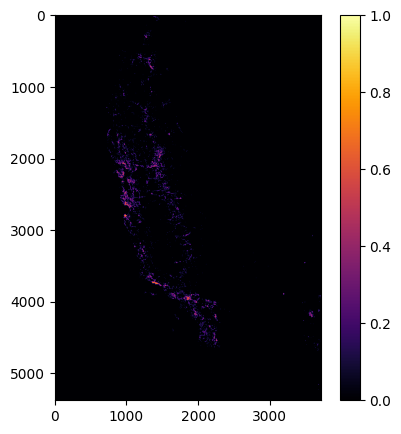

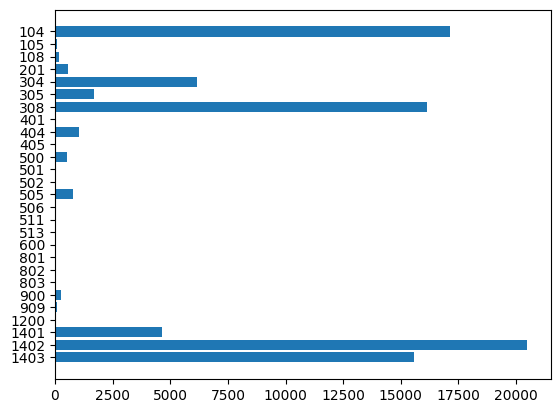

Bird: Steller's Jay
Retrieved squares: 23487


<Figure size 500x500 with 0 Axes>

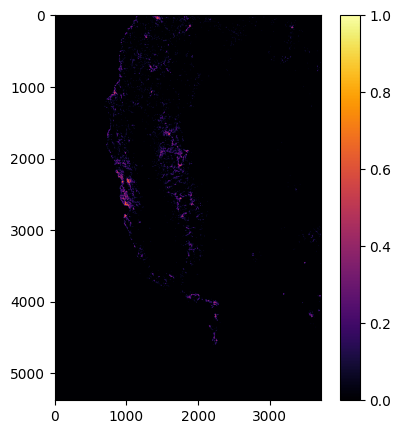

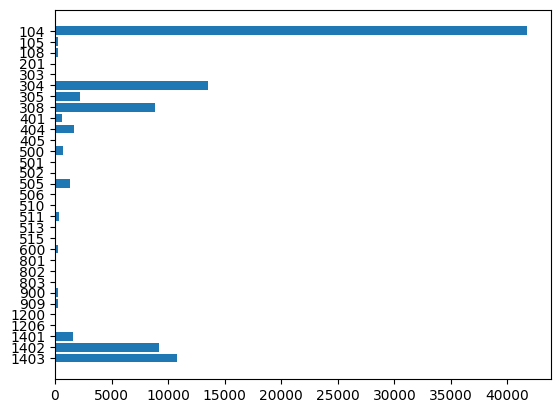

In [6]:
# Define the ebird squares desired.
max_dist = 2 # Max distance travelled in checklist
breeding = False # set to True or False to filter by breeding
date_range = ("2012-01-01", "2018-12-31")
state = "US-CA" # State, to limit the query.

for bird in birds:
    print("Bird:", bird.name)
    hab = bird.habitat_fn
    repop = bird.repopulation_fn

    # Get the list of squares where the bird has been seen.
    squares = ebird_interface.get_squares_with_bird(bird.name, max_dist=max_dist,
                                                    breeding=breeding, date_range=date_range,
                                                    state=state, verbose=False)

    print("Retrieved squares:", len(squares))
    # Creates a new geotiff, pained with each square according to where the bird
    # has been seen.  This is used to take care of overlaps between nearby squares,
    # and it also makes the computation faster.
    seen_tif = ter.clone_shape(os.path.expanduser("~/temp/tempterrain.tif"))
    seen_tile = Tile(seen_tif.width, seen_tif.height, 0, 1, 0, 0, np.zeros((1, seen_tif.width, seen_tif.height)))
    seen_tif.set_tile(seen_tile)

    for square in squares:
        coord = ebird_db.format_coords(square)
        xy = ebird_db.transform_coords(ter, coord)
        seen_tif.set_tile_from_coord(xy, 1, tile_scale=int(max_dist * 3 / 2))

    # Displays the geotiff, just for the fun of it.
    seen_tif.draw_geotiff()

    # Gets all the terrain that has been seen.
    seen_tile = seen_tif.get_tile(seen_tif.width, seen_tif.height, 0, 0, 0)
    ter_tile = ter.get_tile(seen_tif.width, seen_tif.height, 0, 0, 0)
    seen_terrain = np.multiply(seen_tile.m, ter_tile.m)

    hist, bins = np.histogram(seen_terrain, bins = np.delete(np.unique(seen_terrain), 0))
    terrain_histogram = dict(zip(bins, hist))

    # get terrain making up 90% of occurences
    sorted_terrain_histogram = {}
    for w in sorted(terrain_histogram, key=terrain_histogram.get, reverse=True):
        sorted_terrain_histogram[int(w)] = int(terrain_histogram[w])

    # Displays the histogram.
    plot_histogram(sorted_terrain_histogram)

    # export to JSON and CSV
    with open(bird.terrain_histogram_json_fn, "w") as outfile:
        json.dump(sorted_terrain_histogram, outfile, indent=2)

    with open(bird.terrain_histogram_csv_fn, 'w') as f:
        for key in sorted_terrain_histogram.keys():
            f.write("%s,%s\n"%(key, sorted_terrain_histogram[key]))